## Importing necessary libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk

In [3]:
messages=[line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [4]:
print(len(messages))

5574


In [5]:
for mess_no,message in enumerate(messages[:10]):
    print(mess_no,message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

##  Importing CSV file

In [13]:
messages=pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [14]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory data analysis

In [15]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [17]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [18]:
messages['length']=messages['message'].apply(len)

In [19]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<Axes: ylabel='Frequency'>

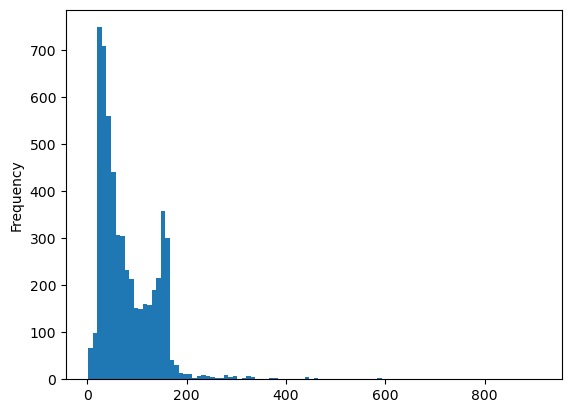

In [21]:
messages['length'].plot.hist(bins=100)

In [23]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

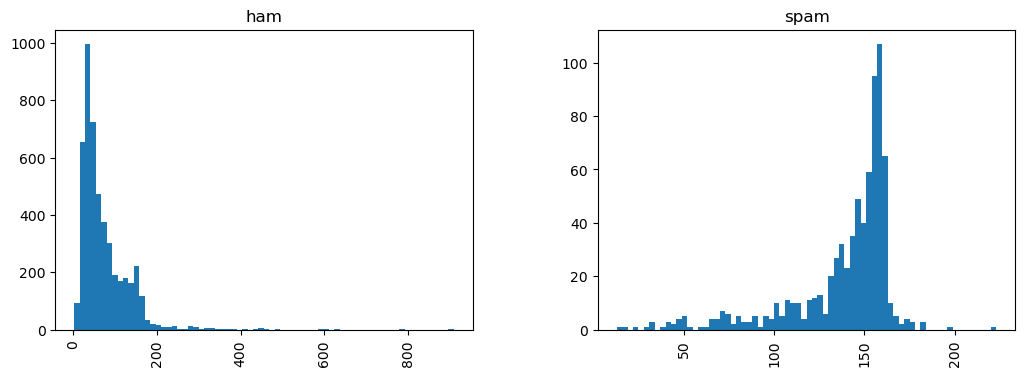

In [25]:
messages.hist(column='length',by='label',bins=70,figsize=(12,4))

## Text preprocessing

In [26]:
import string

In [27]:
from nltk.corpus import stopwords

In [28]:
def text_process(mess):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of clean text words
    """
    
    nopunc=[char for char in mess if  char not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    return([word for word in nopunc.split() if  word.lower() not in stopwords.words('english')])

In [29]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [31]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
bow_transformer=CountVectorizer(analyzer=text_process).fit(messages['message'])

In [40]:
print(len(bow_transformer.vocabulary_))

11425


In [41]:
mess4=messages['message'][3]

In [42]:
mess4

'U dun say so early hor... U c already then say...'

In [43]:
bow4=bow_transformer.transform([mess4])

In [44]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [45]:
print(bow4.shape)

(1, 11425)


In [46]:
bow_transformer.get_feature_names_out()[4068]

'U'

In [50]:
messages_bow=bow_transformer.transform(messages['message'])

In [51]:
print('Shape of Sparse matrix: ',messages_bow.shape)

Shape of Sparse matrix:  (5572, 11425)


In [52]:
messages_bow.nnz

50548

In [53]:
sparsity=100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])
print('sparsity : {}'.format(sparsity))

sparsity : 0.07940295412668218


In [54]:
from sklearn.feature_extraction.text import TfidfTransformer

In [56]:
tfidf_transformer=TfidfTransformer().fit(messages_bow)

In [59]:
messages_tfidf=tfidf_transformer.transform(messages_bow)

## Splitting our data into training and testing set

In [66]:
from sklearn.model_selection import train_test_split

In [83]:
msg_train, msg_test, label_train, label_test = train_test_split(messages_tfidf,messages['label'], test_size=0.3)

## Training Our model

 #### 1. Multinomial Naive Bayes Algorithm

In [85]:
from sklearn.naive_bayes import MultinomialNB
multinomial = MultinomialNB()

multinomial.fit(msg_train,label_train)

MultinomialNB()

### Classification report

In [74]:
from sklearn.metrics import classification_report,confusion_matrix

In [90]:
label_pred = multinomial.predict(msg_test)

In [91]:
print(classification_report(label_test,label_pred))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1450
        spam       1.00      0.68      0.81       222

    accuracy                           0.96      1672
   macro avg       0.98      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672



In [92]:
print(confusion_matrix(label_test,label_pred))

[[1450    0]
 [  70  152]]


#### 2. Random Forest Classifier Algorithm

In [86]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest.fit(msg_train,label_train)

RandomForestClassifier()

In [93]:
label_pred = forest.predict(msg_test)

In [94]:
print(classification_report(label_test,label_pred))
print('\n')
print(confusion_matrix(label_test,label_pred))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1450
        spam       0.99      0.81      0.89       222

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672



[[1449    1]
 [  43  179]]
